In [1]:

from highway_env.envs import HighwayEnv
from gymnasium.wrappers import TimeLimit
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import gymnasium as gym
import highway_env
import heapq

In [2]:
EPISODES = 1000
# ALPHA = 0.1
GAMMA = 0.97
# EPS = 0.1

In [3]:
q_learning_lengths = []
double_q_learning_lengths = []
prioritized_sweeping_lengths = []

#### State Discretization

The continuous state space is converted to discrete bins using `np.digitize`.  
We focus on the ego vehicle's position and speed to generate a state tuple for use with tabular methods.


In [4]:

# Discretization bins for all 5 features: presence, x, y, vx, vy
PRESENCE_BINS = np.array([0, 0.5, 1.0])  # Binary, but with binning for safety
POSITION_BINS = np.linspace(0, 1, 6)     # x
LANE_BINS = np.linspace(0, 1, 3)         # y
VX_BINS = np.linspace(0, 1, 5)           # vx
VY_BINS = np.linspace(0, 1, 5)           # vy

def discretize(obs_row):
    # obs_row = [presence, x, y, vx, vy]
    presence = obs_row[0]
    x = obs_row[1]
    y = obs_row[2]
    vx = obs_row[3]
    vy = obs_row[4]

    presence_bin = int(np.digitize(presence, PRESENCE_BINS))
    x_bin = int(np.digitize(x, POSITION_BINS))
    y_bin = int(np.digitize(y, LANE_BINS))
    vx_bin = int(np.digitize(vx, VX_BINS))
    vy_bin = int(np.digitize(vy, VY_BINS))

    return (presence_bin, x_bin, y_bin, vx_bin, vy_bin)
        

#### Custom Reward Function

We use a shaped reward function to guide learning:
- Rewards for driving fast and staying in the center lane
- Penalties for crashing or unsafe lane changes

This encourages smoother, safer, and more realistic driving policies.


In [5]:
def reward_function(env):
    reward = 0.0
    vehicle = env.unwrapped.vehicle
    config = env.unwrapped.config

    # Encourage high speed
    max_speed = config.get("max_speed", 30)
    reward += (vehicle.speed / max_speed) * 2.0  # Scaled to have a maximum of 2.0

    # Penalize collisions
    if vehicle.crashed:
        reward -= 10.0

    # Promote lane discipline (assuming center lane is index 1)
    if vehicle.lane_index[2] == 1:
        reward += 0.5
    else:
        reward -= 0.1  # Slight penalty for being off-center

    # Discourage unnecessary lane changes
    if hasattr(vehicle, 'previous_lane_index') and vehicle.lane_index != vehicle.previous_lane_index:
        reward -= 0.2  # Penalty for lane change
    vehicle.previous_lane_index = vehicle.lane_index

    # Encourage safe overtaking
    if hasattr(vehicle, 'overtake_count'):
        if vehicle.overtake_count > 0:
            reward += 0.3 * vehicle.overtake_count
    else:
        vehicle.overtake_count = 0

    return reward


#### Environment Setup

We configure the `highway-env` environment with:
- 5 vehicles
- Kinematic observations (`x`, `y`, `vx`, `vy`)
- Discrete meta-actions (lane changes, acceleration)
- Reduced duration and frequency for faster training


In [6]:
base_env = HighwayEnv()
# base_env.configure(config)
base_env.configure({
    "vehicles_count": 5,
    "duration": 30,
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order": "sorted"
    },
    "action": {
        "type": "DiscreteMetaAction"
    }
})
env = TimeLimit(base_env, max_episode_steps=40)
env.reset()

(array([[ 1.        ,  1.        ,  0.04      ,  1.        ,  0.        ],
        [ 1.        ,  0.21950123,  0.08      , -0.08861073,  0.        ],
        [ 1.        ,  0.42057616,  0.        , -0.16633466,  0.        ],
        [ 1.        ,  0.6269249 , -0.04      , -0.05738091,  0.        ],
        [ 1.        ,  0.8339708 ,  0.08      , -0.10556791,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 4,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 0.3333333333333333,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

#### Q-Learning

Q-learning with EPS-greedy exploration.  
Rewards and episode lengths are logged for every episode.  


In [7]:

EPS = 1.0         # start with full exploration
MIN_EPS = 0.05
EPS_DECAY = 0.995

ALPHA = 0.1       # fixed for now; can decay if needed
MIN_ALPHA = 0.01
ALPHA_DECAY = 0.99

q_learning_rewards = []
Q = defaultdict(lambda: np.zeros(env.action_space.n))


for ep in range(EPISODES):
    obs, _ = env.reset()
    state = discretize(obs[0])
    done = False
    total_reward = 0
    episode_length = 0

    while not done:
        if random.random() < EPS:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, _, terminated, truncated, _ = env.step(action)
        next_state = discretize(next_obs[0])
        reward = reward_function(env)
        done = terminated or truncated
        total_reward += reward

        best_next_action = np.argmax(Q[next_state])
        Q[state][action] += ALPHA * (reward + GAMMA * Q[next_state][best_next_action] - Q[state][action])
        state = next_state
        episode_length += 1

    q_learning_rewards.append(total_reward)
    q_learning_lengths.append(episode_length) 
    if (ep + 1) % 10 == 0:
        print(f"Episode {ep + 1}/{EPISODES}, EPS: {EPS:.4f}, Reward: {total_reward}, Steps: {episode_length}", flush=True)
    # Decay after each episode
    EPS = max(MIN_EPS, EPS * EPS_DECAY)
    ALPHA = max(MIN_ALPHA, ALPHA * ALPHA_DECAY)

Episode 10/1000, EPS: 0.9559, Reward: 4.0472574500908305, Steps: 8
Episode 20/1000, EPS: 0.9092, Reward: 58.84341022688509, Steps: 40
Episode 30/1000, EPS: 0.8647, Reward: 48.30329541772521, Steps: 32
Episode 40/1000, EPS: 0.8224, Reward: 67.05251635806897, Steps: 40
Episode 50/1000, EPS: 0.7822, Reward: 8.68702098620775, Steps: 9
Episode 60/1000, EPS: 0.7440, Reward: 63.44970175876374, Steps: 40
Episode 70/1000, EPS: 0.7076, Reward: 35.56125830280026, Steps: 34
Episode 80/1000, EPS: 0.6730, Reward: 82.92090061307165, Steps: 40
Episode 90/1000, EPS: 0.6401, Reward: 24.968254215554467, Steps: 19
Episode 100/1000, EPS: 0.6088, Reward: 72.21633707707403, Steps: 40
Episode 110/1000, EPS: 0.5790, Reward: 27.46071998597271, Steps: 25
Episode 120/1000, EPS: 0.5507, Reward: 69.04483915847484, Steps: 40
Episode 130/1000, EPS: 0.5238, Reward: 19.53746718202222, Steps: 15
Episode 140/1000, EPS: 0.4982, Reward: 73.81390147771383, Steps: 40
Episode 150/1000, EPS: 0.4738, Reward: 13.631087688283987,

#### Double Q-Learning

This method uses two value functions (Q1 and Q2) to reduce overestimation bias.  
Each step randomly updates one table using the other as a reference.


In [ ]:

EPS = 1.0         # start with full exploration
MIN_EPS = 0.05
EPS_DECAY = 0.995

ALPHA = 0.1       # fixed for now; can decay if needed
MIN_ALPHA = 0.01
ALPHA_DECAY = 0.99

Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
double_q_learning_rewards = []

for ep in range(EPISODES):
    obs, _ = env.reset()
    state = discretize(obs[0])
    done = False
    total_reward = 0
    episode_length = 0

    while not done:
        if random.random() < EPS:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q1[state] + Q2[state])

        next_obs, _, terminated, truncated, _ = env.step(action)
        next_state = discretize(next_obs[0])
        reward = reward_function(env)
        done = terminated or truncated
        total_reward += reward

        if random.random() < 0.5:
            a_star = np.argmax(Q1[next_state])
            Q1[state][action] += ALPHA * (reward + GAMMA * Q2[next_state][a_star] - Q1[state][action])
        else:
            a_star = np.argmax(Q2[next_state])
            Q2[state][action] += ALPHA * (reward + GAMMA * Q1[next_state][a_star] - Q2[state][action])

        state = next_state
        episode_length += 1

    double_q_learning_rewards.append(total_reward)
    double_q_learning_lengths.append(episode_length)
    if (ep + 1) % 10 == 0:
        print(f"Episode {ep + 1}/{EPISODES}, EPS: {EPS:.4f}, Reward: {total_reward}, Steps: {episode_length}", flush=True)
    # Decay epsilon and alpha
    EPS = max(MIN_EPS, EPS * EPS_DECAY)
    ALPHA = max(MIN_ALPHA, ALPHA * ALPHA_DECAY)


Episode 10/1000, EPS: 0.9559, Reward: 66.55062863681108, Steps: 40
Episode 20/1000, EPS: 0.9092, Reward: 21.101560855510673, Steps: 18
Episode 30/1000, EPS: 0.8647, Reward: 60.8018617554859, Steps: 40
Episode 40/1000, EPS: 0.8224, Reward: 67.69387736144735, Steps: 40
Episode 50/1000, EPS: 0.7822, Reward: 79.28892365211456, Steps: 40
Episode 60/1000, EPS: 0.7440, Reward: 14.12930662443517, Steps: 13
Episode 70/1000, EPS: 0.7076, Reward: 55.92350671181517, Steps: 40
Episode 80/1000, EPS: 0.6730, Reward: 56.83353146467951, Steps: 37
Episode 90/1000, EPS: 0.6401, Reward: 64.16240778122989, Steps: 40
Episode 100/1000, EPS: 0.6088, Reward: 63.0018144414084, Steps: 40
Episode 110/1000, EPS: 0.5790, Reward: 62.00692175194719, Steps: 40
Episode 120/1000, EPS: 0.5507, Reward: 53.09435770626602, Steps: 40
Episode 130/1000, EPS: 0.5238, Reward: 41.522237761444735, Steps: 35
Episode 140/1000, EPS: 0.4982, Reward: 69.22132784311495, Steps: 40
Episode 150/1000, EPS: 0.4738, Reward: 67.07603292028242,

#### Prioritized Sweeping

This model-based method prioritizes updates to the most surprising transitions (highest TD error).  
It helps improve sample efficiency.


In [ ]:

EPS = 1.0         # start with full exploration
MIN_EPS = 0.05
EPS_DECAY = 0.995

ALPHA = 0.1       # fixed for now; can decay if needed
MIN_ALPHA = 0.01
ALPHA_DECAY = 0.99

Q = defaultdict(lambda: np.zeros(env.action_space.n))
model = {}
priority_queue = []
theta = 0.01
planning_steps = 10
prioritized_sweeping_rewards = []

def update_priority(s, a, r, s_prime):
    priority = abs(r + GAMMA * np.max(Q[s_prime]) - Q[s][a])
    if priority > theta:
        heapq.heappush(priority_queue, (-priority, s, a))

for ep in range(EPISODES):
    obs, _ = env.reset()
    state = discretize(obs[0])
    done = False
    total_reward = 0
    episode_length = 0

    while not done:
        if random.random() < EPS:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, _, terminated, truncated, _ = env.step(action)
        next_state = discretize(next_obs[0])
        reward = reward_function(env)
        done = terminated or truncated
        total_reward += reward

        model[(state, action)] = (reward, next_state)
        update_priority(state, action, reward, next_state)

        for _ in range(planning_steps):
            if not priority_queue:
                break
            _, s, a = heapq.heappop(priority_queue)
            r, s_prime = model[(s, a)]
            Q[s][a] += ALPHA * (r + GAMMA * np.max(Q[s_prime]) - Q[s][a])

            for (sprev, aprev), (rprev, s_next) in model.items():
                if s_next == s:
                    update_priority(sprev, aprev, rprev, s)
        state = next_state
        episode_length+=1

    prioritized_sweeping_rewards.append(total_reward)
    prioritized_sweeping_lengths.append(episode_length)
    if (ep + 1) % 10 == 0:
        print(f"Episode {ep + 1}/{EPISODES}, EPS: {EPS:.4f}, Reward: {total_reward}, Steps: {episode_length}", flush=True)
    # Decay epsilon and alpha
    EPS = max(MIN_EPS, EPS * EPS_DECAY)
    ALPHA = max(MIN_ALPHA, ALPHA * ALPHA_DECAY)



Episode 10/1000, EPS: 0.9559, Reward: 18.639012333217963, Steps: 14
Episode 20/1000, EPS: 0.9092, Reward: 71.09855898462388, Steps: 40
Episode 30/1000, EPS: 0.8647, Reward: 9.64791824290105, Steps: 11
Episode 40/1000, EPS: 0.8224, Reward: 60.547030314491586, Steps: 40
Episode 50/1000, EPS: 0.7822, Reward: 62.36998866113113, Steps: 40
Episode 60/1000, EPS: 0.7440, Reward: 31.916608849745536, Steps: 29
Episode 70/1000, EPS: 0.7076, Reward: 57.9888516355738, Steps: 40
Episode 80/1000, EPS: 0.6730, Reward: 21.94631747091499, Steps: 15
Episode 90/1000, EPS: 0.6401, Reward: 20.056934911789206, Steps: 16
Episode 100/1000, EPS: 0.6088, Reward: 71.10857101001052, Steps: 40
Episode 110/1000, EPS: 0.5790, Reward: 23.91554157104449, Steps: 23
Episode 120/1000, EPS: 0.5507, Reward: 60.452806891915735, Steps: 40
Episode 130/1000, EPS: 0.5238, Reward: 30.047507499474982, Steps: 21
Episode 140/1000, EPS: 0.4982, Reward: 64.46134289127986, Steps: 40
Episode 150/1000, EPS: 0.4738, Reward: 70.06100526773

In [ ]:
import numpy as np

# Number of episodes to average over at the end
last_n = 100

print(f"{'Method':<25} | {'Avg Reward':<10} | {'Std Dev':<10} | {'Final Reward':<10}")
print("-" * 65)

results = {
    "Q-learning": {"rewards": q_learning_rewards},
    "Double Q-learning": {"rewards": double_q_learning_rewards},
    "Prioritized Sweeping": {"rewards": prioritized_sweeping_rewards}
}


for method, data in results.items():
    rewards = np.array(data['rewards'])
    if len(rewards) < last_n:
        avg_reward = rewards.mean()
        std_reward = rewards.std()
        final_reward = rewards[-1]
    else:
        avg_reward = rewards[-last_n:].mean()
        std_reward = rewards[-last_n:].std()
        final_reward = rewards[-1]
    
    print(f"{method:<25} | {avg_reward:<10.2f} | {std_reward:<10.2f} | {final_reward:<10.2f}")


Method                    | Avg Reward | Std Dev    | Final Reward
-----------------------------------------------------------------
Q-learning                | 51.97      | 27.64      | 75.21     
Double Q-learning         | 60.56      | 28.49      | 15.56     
Prioritized Sweeping      | 56.26      | 13.89      | 50.95     


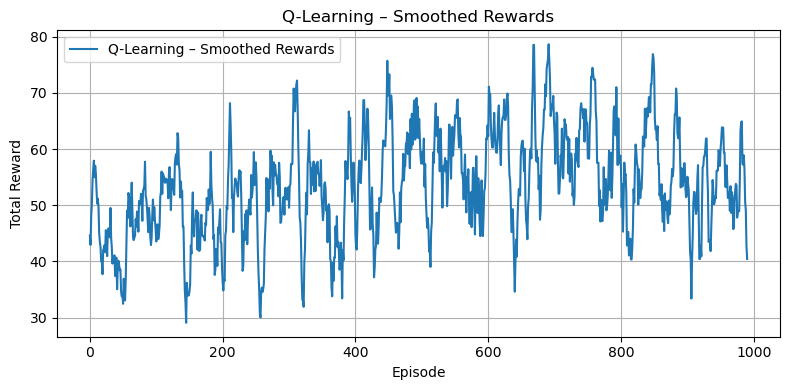

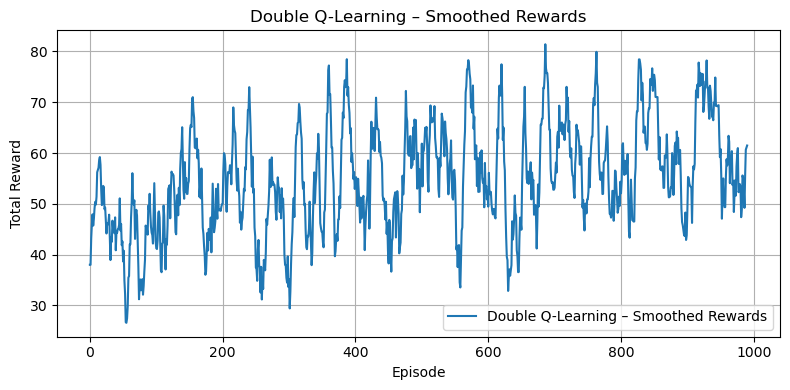

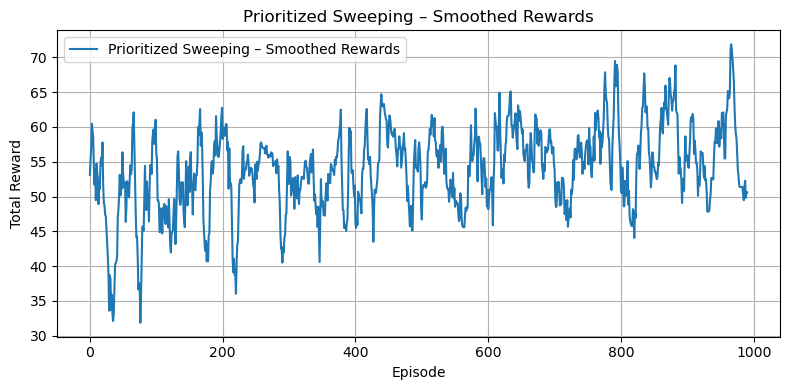

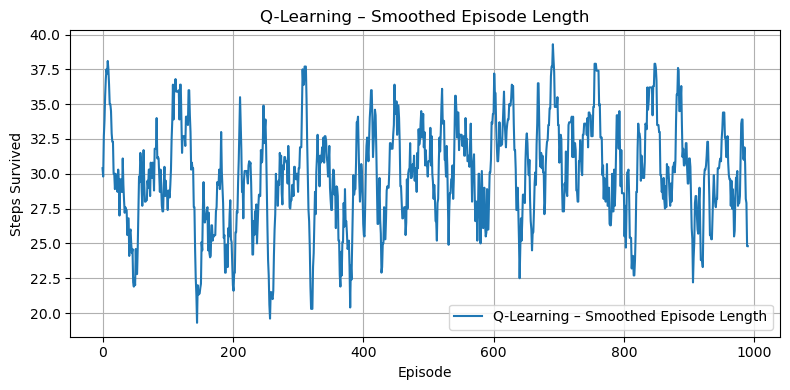

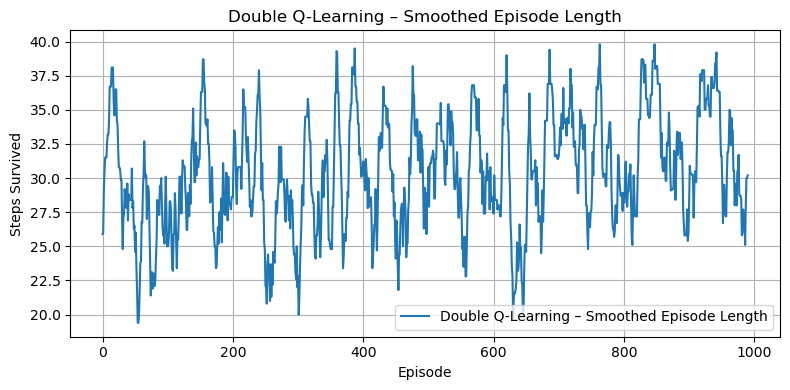

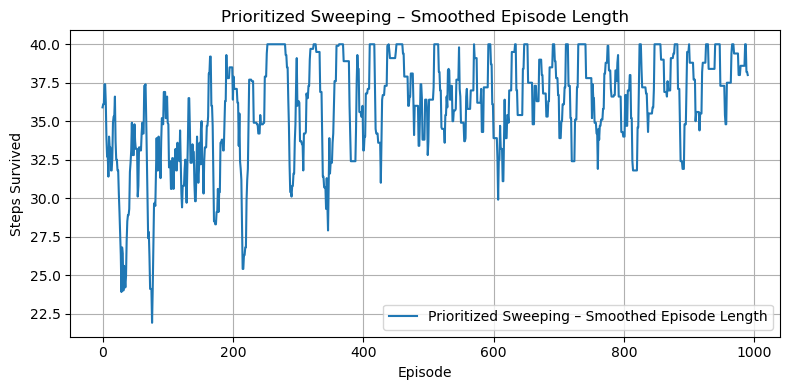

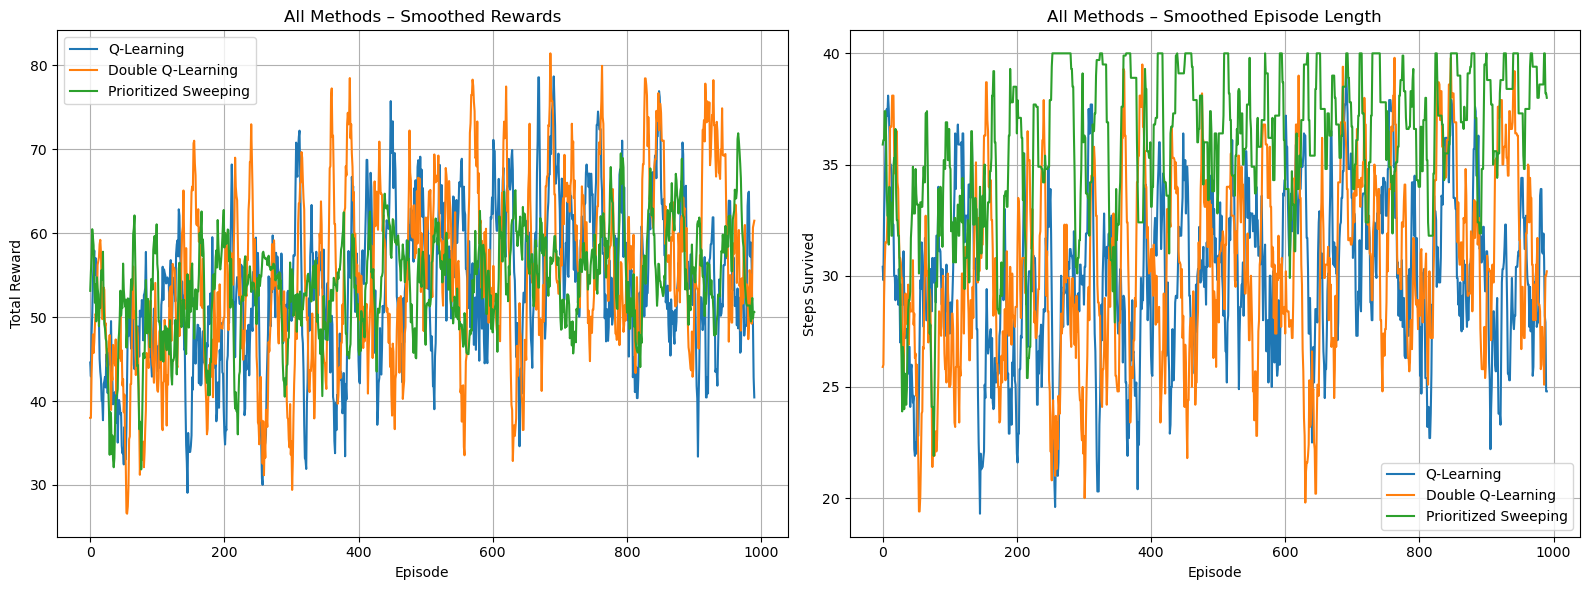

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Smoothing function
def smooth(data, window=10):
    if len(data) < window:
        return data
    return np.convolve(data, np.ones(window) / window, mode='valid')

# Create a folder to save your plots
save_dir = "plots"
os.makedirs(save_dir, exist_ok=True)

# Function to save a single plot
def save_plot(data, title, ylabel, filename):
    plt.figure(figsize=(8, 4))
    plt.plot(smooth(data), label=title)
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, filename), format="pdf")
    plt.show()
    plt.close()

# Save individual reward plots
save_plot(q_learning_rewards, 'Q-Learning – Smoothed Rewards', 'Total Reward', 'q_learning_reward.pdf')
save_plot(double_q_learning_rewards, 'Double Q-Learning – Smoothed Rewards', 'Total Reward', 'double_q_learning_reward.pdf')
save_plot(prioritized_sweeping_rewards, 'Prioritized Sweeping – Smoothed Rewards', 'Total Reward', 'prioritized_sweeping_reward.pdf')

# Save individual episode length plots
save_plot(q_learning_lengths, 'Q-Learning – Smoothed Episode Length', 'Steps Survived', 'q_learning_length.pdf')
save_plot(double_q_learning_lengths, 'Double Q-Learning – Smoothed Episode Length', 'Steps Survived', 'double_q_learning_length.pdf')
save_plot(prioritized_sweeping_lengths, 'Prioritized Sweeping – Smoothed Episode Length', 'Steps Survived', 'prioritized_sweeping_length.pdf')

# Combined comparison plot
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(smooth(q_learning_rewards), label='Q-Learning')
axs[0].plot(smooth(double_q_learning_rewards), label='Double Q-Learning')
axs[0].plot(smooth(prioritized_sweeping_rewards), label='Prioritized Sweeping')
axs[0].set_title('All Methods – Smoothed Rewards')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Reward')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(smooth(q_learning_lengths), label='Q-Learning')
axs[1].plot(smooth(double_q_learning_lengths), label='Double Q-Learning')
axs[1].plot(smooth(prioritized_sweeping_lengths), label='Prioritized Sweeping')
axs[1].set_title('All Methods – Smoothed Episode Length')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Steps Survived')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'combined_comparison.pdf'), format='pdf')
plt.show()
plt.close()
